# L4-C - Building your own Quantizer: Quantize any Open Source PyTorch Model

In this lesson, you will look at the results of open source models compressed using the custom quantizer you built.

Run the next cell to import all of the functions you have used before in the previous lesson(s) of `Building your own Quantizer` to follow along with the video.

- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from helper import W8A16LinearLayer, replace_linear_with_target_and_quantize

## Step 3: Test the Implementation on Various LLMs

### 3.1 - [Salesforce/codegen-350M-mono](https://huggingface.co/Salesforce/codegen-350M-mono)

下面我们将在真实的模型上测试自己编写的量化器。

首先，让我们测试Salesforce/codegen-350M-mono模型，这是一个仅有3.5亿参数的语言模型，该模型用于生成code。

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_id = "Salesforce/codegen-350M-mono"

model = AutoModelForCausalLM.from_pretrained(model_id, 
                                    torch_dtype=torch.bfloat16, 
                                             low_cpu_mem_usage=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

/home/haoyu/anaconda3/envs/INT8/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at ./models/Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.

In [3]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [4]:
# 用上面定义的”text-generation” pipeline生成一些文本
print(pipe("def hello_world():", max_new_tokens=20, do_sample=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'def hello_world():\n    print("Hello World")\n\nhello_world()\n\n# 파'}]


In [5]:
# 打印量化之前的模型
print("Model before:\n\n", model)

Model before:

 CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): CodeGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bi

In [6]:
# 调用replace_linear_with_target_and_quantize函数，替换模型中除”lm_head”以外的线性层并进行量化
replace_linear_with_target_and_quantize(model, 
                                        W8A16LinearLayer, ["lm_head"])

In [7]:
# 请注意，replace_linear_with_target_and_quantize方法会直接修改模型，所以我们只需要打印pipe.model就能看到线性层替换结果。
# 可以看到，除了”lm_head”以外的线性层都被替换成了W8A16LinearLayer。
# 我们之所以不替换lm_head层，是因为这是一个自回归模型，它使用上一次迭代的输出来做为下一次迭代的输入。如果量化lm_head层，那么在生成步骤中会积累很多误差。
pipe.model

CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): W8A16LinearLayer()
          (out_proj): W8A16LinearLayer()
        )
        (mlp): CodeGenMLP(
          (fc_in): W8A16LinearLayer()
          (fc_out): W8A16LinearLayer()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias=True)
)

In [8]:
# 用量化后的模型做一些生成，看起来效果与量化前类似，这就说明我们的量化器工作正常
print(pipe("def hello_world():", max_new_tokens=20, 
           do_sample=False)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def hello_world():
    print("Hello World")

# hello_world()

# def hello_


### 3.2 - [facebook/detr-resnet-50](https://huggingface.co/facebook/detr-resnet-50)

In [9]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests

# you can specify the revision tag if you don't want the timm dependency
"""
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")
"""

# 使用上面的方式总是出现网络问题，直接指定本地路径可以成功
processor = DetrImageProcessor.from_pretrained(
    "/home/haoyu/.cache/huggingface/hub/models--facebook--detr-resnet-50/snapshots/70120ba84d68ca1211e007c4fb61d0cd5424be54", revision="no_timm")
model = DetrForObjectDetection.from_pretrained(
    "/home/haoyu/.cache/huggingface/hub/models--facebook--detr-resnet-50/snapshots/70120ba84d68ca1211e007c4fb61d0cd5424be54", revision="no_timm")

In [10]:
# 取得原始模型的内存占用量
previous_memory_footprint = model.get_memory_footprint()

In [11]:
# 原始模型占用166M内存
print("Footprint of the model in MBs: ", 
      previous_memory_footprint/1e+6)

Footprint of the model in MBs:  166.524032


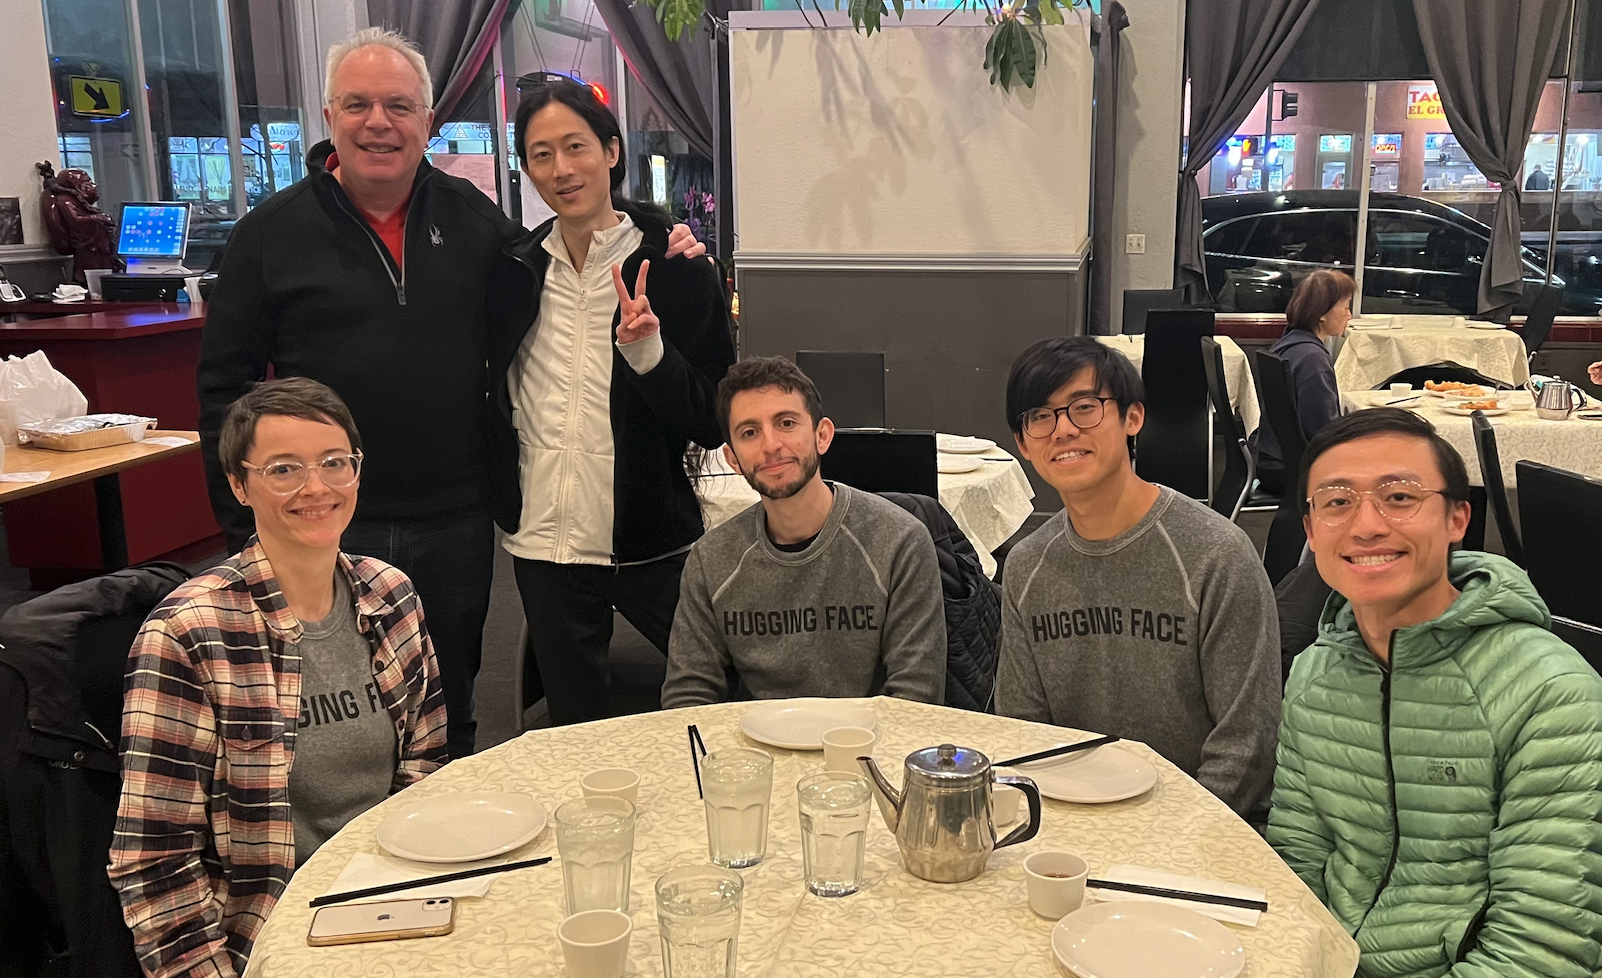

In [12]:
# 打开一张测试图片
img_path = "dinner_with_friends.png"
image = Image.open(img_path).convert("RGB")
image

In [13]:
# 使用原始DETR模型做目标检测

from helper import plot_results

inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

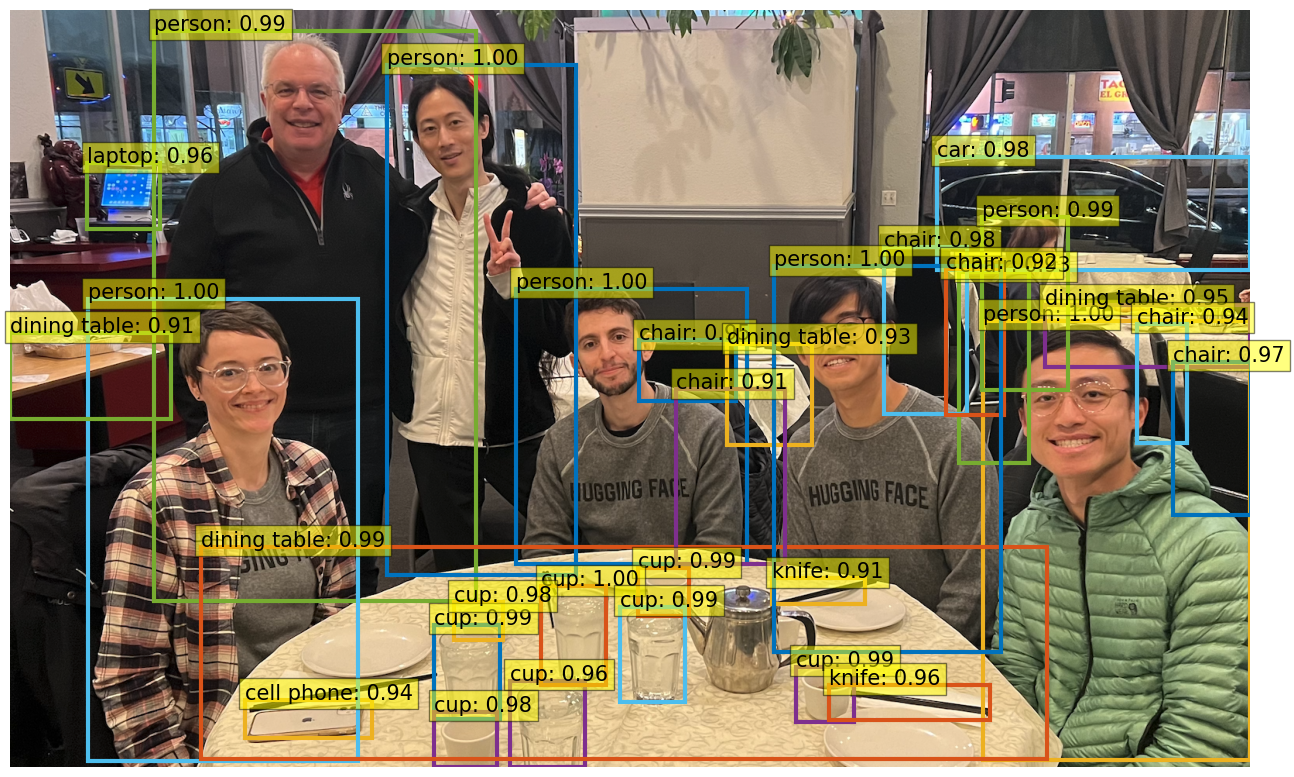

In [14]:
# 原始DETR模型目标检测效果
plot_results(model, image, results)

In [15]:
# 查看原始DETR模型结构，可以看到有许多Linear层
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [16]:
# 替换原始DETR模型中的线性层并进行量化，排除name为["0", "1", "2", "class_labels_classifier"]的线性层
replace_linear_with_target_and_quantize(model, 
                                        W8A16LinearLayer, 
               ["0", "1", "2", "class_labels_classifier"])

In [17]:
# 查看替换并量化后的模型结构，可以看到，除了指定排除的层，其他Linear层已经被替换为W8A16LinearLayer。
### Model after quantization
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

- Visualize results after quantization.

In [18]:
# 使用量化后的模型做目标检测
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

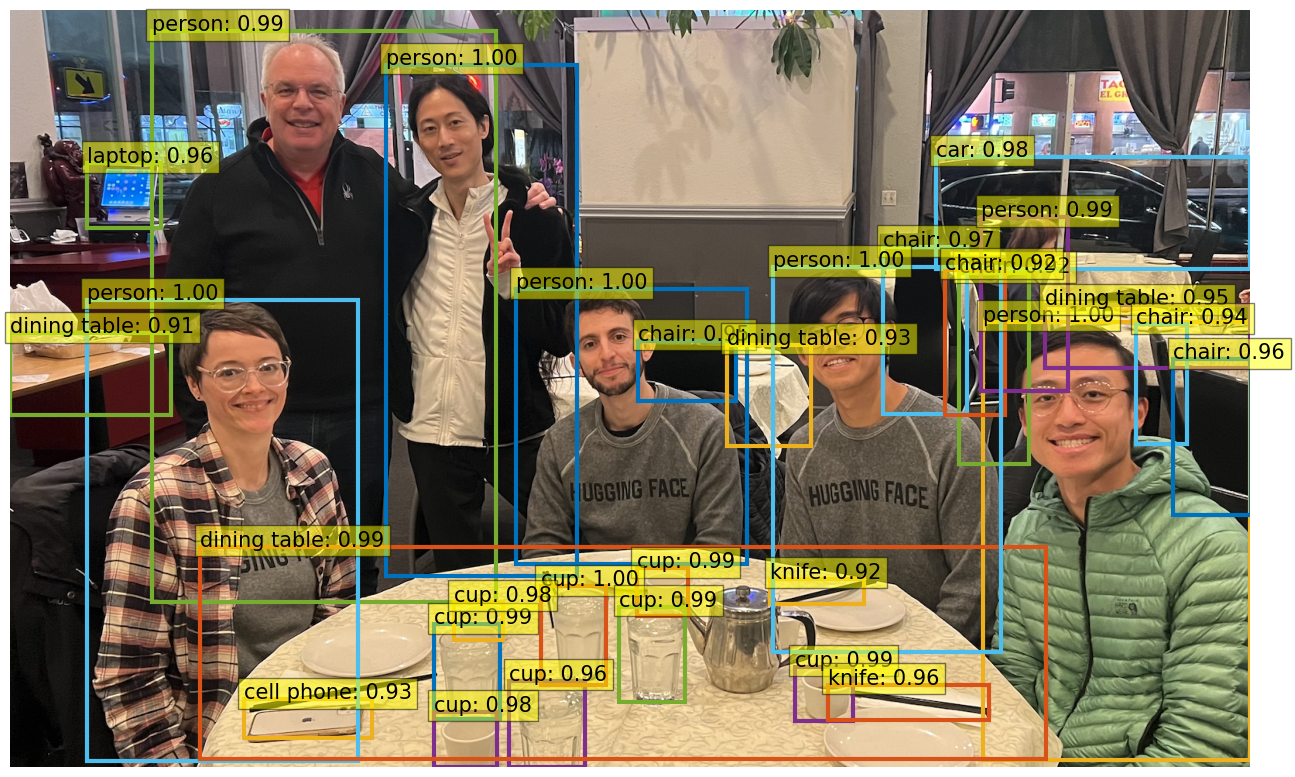

In [19]:
# 查看量化后模型的目标检测效果，与量化前类似
plot_results(model, image, results)

In [20]:
# 取得量化后模型的内存占用量
new_footprint = model.get_memory_footprint()

In [21]:
# 量化后模型占用114M内存
print("Footprint of the model in MBs: ", 
      new_footprint/1e+6)

Footprint of the model in MBs:  114.80384


In [22]:
# 量化后模型比原始模型少占用50M内存
### Memory saved
print("Memory saved in MBs: ", 
      (previous_memory_footprint - new_footprint)/1e+6)

Memory saved in MBs:  51.720192
